In [7]:
%matplotlib inline
import geopandas as gpd
from shapely.geometry import *

### data is from: https://data.london.gov.uk/dataset/statistical-gis-boundary-files-london 
london = gpd.read_file('../data/London_Ward.shp')
### from the prj file: http://www.prj2epsg.org/epsg/27700
london = london.to_crs({'init': 'epsg:4277'})  
london.plot()


#london.head()

ModuleNotFoundError: No module named 'matplotlib'

In [3]:
import sys
import numpy as np
import datetime
import numpy as np
import geojson
from scipy import stats

### path to data
venues = "../../../raw_data/venues/London_venues.txt"
transitions = "../../../raw_data/transitions/London_transitions.txt"

### venue ID -> coordinates for that venue
venue_id_to_coords = {}
with open(venues, 'r') as f:
    for rows in f:
        rows = rows.split("\t")
        ID = rows[0]
        coordinates = (float(rows[2]), float(rows[3]))
        venue_id_to_coords[ID] = coordinates

### venue ID -> ward that venue is in
venue_id_to_ward = {}
for venue in venue_id_to_coords: 
    coordinates = venue_id_to_coords[venue]
    latitude, longitude = coordinates
    point_of_checkin = Point(longitude, latitude) 
    
    does_contain_point = london.contains(point_of_checkin) 
    contains = does_contain_point[does_contain_point == True]     
    if len(contains) > 0:
        ward = contains.index[0] 
        venue_id_to_ward[venue] = ward

In [4]:
### create a map of venue (specifically, their ID) 
### to a list of *arrival* times to that venue       
venue_id_to_times = {}
with open(transitions, 'r') as f:
    for rows in f:
        rows = rows.split("\t")
        location1 = rows[0]
        time1 = rows[1]
        location2 = rows[2]
        time2 = rows[3]
        if location1 in venue_id_to_coords and location2 in venue_id_to_coords: 
            timeTravelled = int(time2) - int(time1)
            if timeTravelled > 0:
                # km / hrs
                timeTravelled = (timeTravelled / 60.0)/ 60.0 
                venue_id_to_times.setdefault(location1, [])
                time_cleaned = datetime.datetime.fromtimestamp(int(time1))
                venue_id_to_times[location1].append(time_cleaned)

In [5]:
### hour -> ward -> count 
hour_to_ward_to_count = {}

for x in range(0,24): 
    hour_to_ward_to_count[x] = {}

### for each venue, figure out which ward that venue    
### belongs to and keep track of the numb of checkins into that ward  
for venue_id in venue_id_to_times:
    checkins_to_a_venue = venue_id_to_times[venue_id]
    for checks in checkins_to_a_venue:
        # for now, we'll only look at weekdays 
        if checks.weekday() != 5 and checks.weekday() != 6:  
            if venue_id in venue_id_to_ward:
                ward = venue_id_to_ward[venue_id] 
                inner = hour_to_ward_to_count[checks.hour]
                inner.setdefault(ward, 0)
                inner[ward] += 1
                hour_to_ward_to_count[checks.hour] = inner

In [6]:
# we'll only look at wards that have at least 10 
# checkins during a given hour 
threshold_num_checkins = 10

# hour to ward to count of checkins into that ward 
# at that hour IFF the numb of checkins is over the 
# min threshold (N = 10)
hour_to_ward_to_count_threshold = {}

for x in range(0,24): 
    hour_to_ward_to_count_threshold[x] = {}

for hour in hour_to_ward_to_count_threshold: 
    inner = hour_to_ward_to_count[hour]
    for ward in inner: 
        num_checkins = inner[ward]
        if num_checkins >= threshold_num_checkins:
            (hour_to_ward_to_count_threshold[hour])[ward] = num_checkins

In [7]:
import json
from django.contrib.gis.geos import GeometryCollection, GEOSGeometry

# we want to write our data to a geojson file 
# to do this, we'll create a dictionary representation 
# and then write that data stucture to a file 
geojson = {'type':'FeatureCollection', 'features':[]} 
i = 0
for hour in hour_to_ward_to_count_threshold: 
    inner = hour_to_ward_to_count_threshold[hour]
    for ward in inner:  
        feature = {'type':'Feature',
                    'properties':{},
                    'geometry':{'type':'Polygon',
                                'coordinates':[]}}
 
        count =  hour_to_ward_to_count_threshold[hour][ward]
        feature['properties']['mag'] = count
        feature['properties']['time'] = hour
        feature['properties']['name'] = london.ix[ward]['NAME']
        feature['geometry']['coordinates'] = [list((london.ix[ward])['geometry'].exterior.coords)]
        geojson['features'].append(feature) 
geojson_str = json.dumps(geojson)

In [9]:
# = open("london_wards_inflow.geojson", 'w')
#f.write(geojson_str)
#f.close()

In [152]:
ward_name = "St. Pancras and Somers Town"
#print london[london.NAME == "St. Pancras and Somers Town"].index.tolist()[0]
ward_id_of_interest = 503

# starting monday at midnight  
day_of_week_to_hour_to_num_checkins = {}
for x in range(0,7): 
    day_of_week_to_hour_to_num_checkins[x] = {}

x = 0
for venue_id in venue_id_to_times:
    if venue_id in venue_id_to_ward:
        ward = venue_id_to_ward[venue_id]  
        # IF it's the ward we want to focus on 
        if ward == ward_id_of_interest: 
            # get all checkins into that venue 
            checkins_to_a_venue = venue_id_to_times[venue_id]  
            for check in checkins_to_a_venue: 
                day_of_week = check.weekday()
                # inner dictionary is hour -> checkin for the given day of week
                inner = day_of_week_to_hour_to_num_checkins[day_of_week] 
                inner.setdefault(check.hour, 0)
                inner[check.hour] += 1
                day_of_week_to_hour_to_num_checkins[day_of_week] = inner 
print day_of_week_to_hour_to_num_checkins

503
{0: {0: 18, 1: 11, 2: 4, 3: 3, 4: 9, 5: 43, 6: 220, 7: 535, 8: 1084, 9: 834, 10: 661, 11: 646, 12: 697, 13: 702, 14: 546, 15: 496, 16: 600, 17: 760, 18: 892, 19: 624, 20: 402, 21: 290, 22: 159, 23: 76}, 1: {0: 23, 1: 8, 2: 6, 3: 5, 4: 22, 5: 36, 6: 182, 7: 580, 8: 1167, 9: 919, 10: 765, 11: 641, 12: 668, 13: 681, 14: 569, 15: 478, 16: 639, 17: 808, 18: 1021, 19: 749, 20: 411, 21: 282, 22: 183, 23: 97}, 2: {0: 30, 1: 9, 2: 2, 3: 1, 4: 16, 5: 29, 6: 174, 7: 603, 8: 1200, 9: 887, 10: 741, 11: 663, 12: 665, 13: 639, 14: 616, 15: 519, 16: 648, 17: 845, 18: 1013, 19: 778, 20: 446, 21: 327, 22: 199, 23: 97}, 3: {0: 21, 1: 11, 2: 2, 3: 9, 4: 19, 5: 42, 6: 207, 7: 620, 8: 1088, 9: 844, 10: 729, 11: 669, 12: 771, 13: 744, 14: 601, 15: 534, 16: 716, 17: 894, 18: 1102, 19: 891, 20: 483, 21: 359, 22: 217, 23: 125}, 4: {0: 38, 1: 9, 2: 4, 3: 4, 4: 18, 5: 31, 6: 151, 7: 490, 8: 1022, 9: 839, 10: 775, 11: 748, 12: 841, 13: 823, 14: 738, 15: 680, 16: 765, 17: 1018, 18: 1231, 19: 1013, 20: 650, 21: 

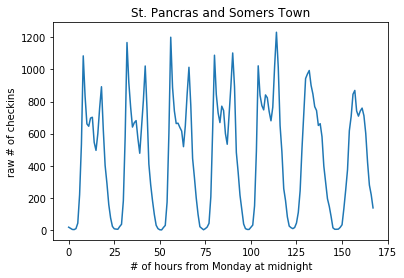

In [64]:
import matplotlib.pyplot as plt

array_data = []
for day in range(0,7): 
    inner = day_of_week_to_hour_to_num_checkins[day]
    for hour in range(0,24): 
        if hour in inner: 
            array_data.append(inner[hour])
        else: 
            array_data.append(0)
            
plt.plot(range(len(array_data)), array_data)
plt.title(ward_name)
plt.ylabel("raw # of checkins")
plt.xlabel("# of hours from Monday at midnight")
plt.show()

In [40]:
hour_to_ward_to_rank = {}

for h in hour_to_ward_to_count_threshold: 
    hour_to_ward_to_rank[h] = {}
    
for h in hour_to_ward_to_count_threshold: 
    inner = hour_to_ward_to_count_threshold[h]  
    x = inner
    rank_cells = {key: rank for rank, key in enumerate(sorted(x, key=x.get, reverse=True), 1)} 
    (hour_to_ward_to_rank[h]) = rank_cells


In [48]:
#ward_to_concatdayhour_to_inflow = {}
#for ward in range(len(london)):
#    ward_to_concatdayhour_to_inflow[ward] = {}

ward_to_hour_to_rank = {}
for ward in range(len(london)):
    ward_to_hour_to_rank[ward] = {}

ward_id_of_interest = 503   
for venue_id in venue_id_to_times:
    if venue_id in venue_id_to_ward:
        ward = venue_id_to_ward[venue_id]  
        inner = ward_to_hour_to_rank[ward] 
        # get all checkins into that venue 
        checkins_to_a_venue = venue_id_to_times[venue_id]  
        for check in checkins_to_a_venue: 
            day_of_week = check.weekday()
            hour_of_day = check.hour
            key = '{:02}'.format(day_of_week) + '{:02}'.format(hour_of_day) 
            key = hour_of_day ### for now, our key is just going to be the hour 
            ward_to_rank = hour_to_ward_to_rank[key]
            if ward in ward_to_rank: 
                rank = (ward_to_rank)[ward]  
                inner.setdefault(key, rank) 
                ward_to_hour_to_rank[day_of_week] = inner   

In [45]:
ward_to_hour_to_rank[503]

{0: 14,
 1: 9,
 2: 18,
 3: 11,
 4: 6,
 5: 7,
 6: 4,
 7: 5,
 8: 6,
 9: 7,
 10: 7,
 11: 8,
 12: 10,
 13: 10,
 14: 11,
 15: 12,
 16: 11,
 17: 11,
 18: 10,
 19: 10,
 20: 11,
 21: 9,
 22: 8,
 23: 8}

In [44]:
# I actually think hour_to_ward_to_rank would be better here . actually maybe not. so, each list in that is our data
# we may need to be making sure that all indices are there for the hours

503

In [49]:
ward_to_hour_to_rank[503]

{0: 14,
 1: 9,
 2: 18,
 3: 11,
 4: 6,
 5: 7,
 6: 4,
 7: 5,
 8: 6,
 9: 7,
 10: 7,
 11: 8,
 12: 10,
 13: 10,
 14: 11,
 15: 12,
 16: 11,
 17: 11,
 18: 10,
 19: 10,
 20: 11,
 21: 9,
 22: 8,
 23: 8}

In [76]:
size = int(len(ward_to_hour_to_rank) *  24)
two_dimen_x_array = np.empty((size, 2)) ## need use a portion of the data  
two_dimen_y_array = np.empty(size)

index = 0
for ward in ward_to_hour_to_rank: 
    hour_to_rank = ward_to_hour_to_rank[ward]
    for hour in hour_to_rank: 
        rank = hour_to_rank[hour] 
        two_dimen_x_array[index] = (ward, hour) #hour
        two_dimen_y_array[index] = rank
        index += 1
    
print (two_dimen_x_array[0:30])
print two_dimen_y_array[0:30]

[[  0.   0.]
 [  0.   1.]
 [  0.   2.]
 [  0.   3.]
 [  0.   4.]
 [  0.   5.]
 [  0.   6.]
 [  0.   7.]
 [  0.   8.]
 [  0.   9.]
 [  0.  10.]
 [  0.  11.]
 [  0.  12.]
 [  0.  13.]
 [  0.  14.]
 [  0.  15.]
 [  0.  16.]
 [  0.  17.]
 [  0.  18.]
 [  0.  19.]
 [  0.  20.]
 [  0.  21.]
 [  0.  22.]
 [  0.  23.]
 [  1.   0.]
 [  1.   1.]
 [  1.   2.]
 [  1.   3.]
 [  1.   4.]
 [  1.   5.]]
[  3.   3.   3.   4.   8.  16.  25.  29.  22.  16.   8.   5.   6.   6.   4.
   4.   4.   6.   8.   8.   8.   7.   7.   5.   3.   3.   3.   4.   8.  16.]


In [90]:
from sklearn.model_selection import train_test_split

x_train, x_temp, y_train, y_temp = train_test_split(two_dimen_x_array, two_dimen_y_array, test_size=0.60, random_state=42)
x_valid, x_test, y_valid, y_test = train_test_split(x_temp, y_temp, test_size=0.50, random_state=42)
print len(two_dimen_x_array), len(x_train), len(x_valid), len(x_test)

<IPython.core.display.Javascript object>


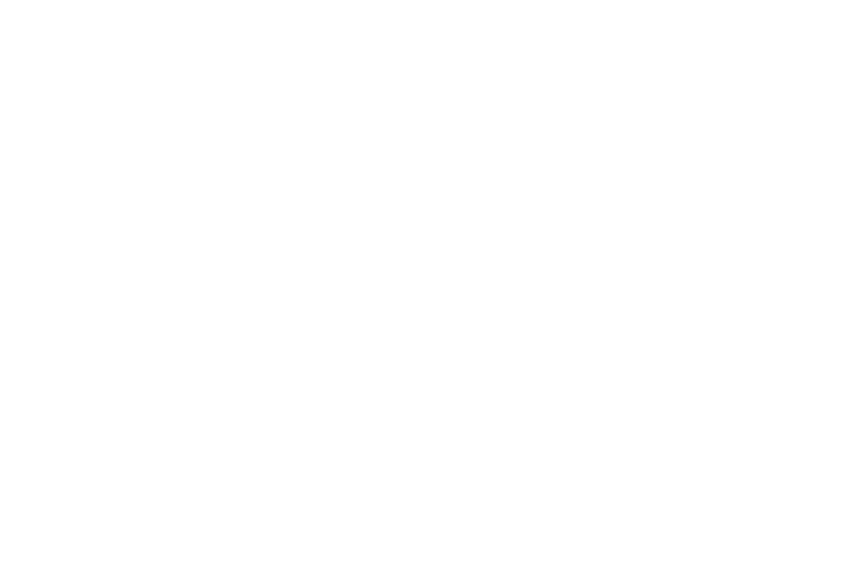

168
---
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  2.  2.  2.  2.  2.  2.
  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.
  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.
  3.  3.  3.  3.  3.  3.  4.  4.  4.  4.  4.  4.  4.  4.  4.  4.  4.  4.
  4.  4.  4.  4.  4.  4.  4.  4.  4.  4.  4.  4.  5.  5.  5.  5.  5.  5.
  5.  5.  5.  5.  5.  5.  5.  5.  5.  5.  5.  5.  5.  5.  5.  5.  5.  5.
  6.  6.  6.  6.  6.  6.  6.  6.  6.  6.  6.  6.  6.  6.  6.  6.  6.  6.
  6.  6.  6.  6.  6.  6.]
[  3.   3.   3.   4.   8.  16.  25.  29.  22.  16.   8.   5.   6.   6.   4.
   4.   4.   6.   8.   8.   8.   7.   7.   5.   3.   3.   3.   4.   8.  16.
  25.  29.  22.  16.   8.   5.   6.   6.   4.   4.   4.   6.   8.   8.   8.
   7.   7.   5.   3.   3.   3.   4.   8.  16.  25.  29.  22.  16.   8.   5.
   6.

In [149]:
#%matplotlib  
x1 = np.empty(7*24) # could be four 
x2 = np.empty(7*24)
y = np.empty(7*24)

i = 0
for elem in two_dimen_x_array[0:(7*24)]:
    items = two_dimen_x_array[i] 
    x1[i] = items[0]
    x2[i] = items[1]
    y[i] = two_dimen_y_array[i] 
    i += 1 
    

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
#ax = fig.add_subplot(111, projection='3d')
#plt.plot(x1, x2, y)
print len(x1)
print '---'
index = 0
print x1
print y

In [151]:
# 1. training data (splitting the data up)
# 2. change to be on a weekly basis (modify the data, not average it)


import numpy as np
from matplotlib import pyplot as plt

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C

from sklearn.kernel_ridge import KernelRidge
from sklearn.model_selection import GridSearchCV
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import WhiteKernel, ExpSineSquared


np.random.seed(1)

# Instanciate a Gaussian Process model
kernel = ExpSineSquared(1.0, 1.0) #= C(1.0, (1e-3, 1e3)) * RBF(10, (1e-2, 1e2))
gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=9)

# Fit to data using Maximum Likelihood Estimation of the parameters
gp.fit(x_train, y_train)

# Make the prediction on the meshed x-axis (ask for MSE as well)
y_pred, sigma = gp.predict(x_valid, return_std=True)
# we're building a covariance matrix that we're going to invert, bayesian rules to do predict 

KeyboardInterrupt: 

15696 6278 4709 4709


In [92]:
print 6278 + 4709 + 4709

15696


ValueError: setting an array element with a sequence.

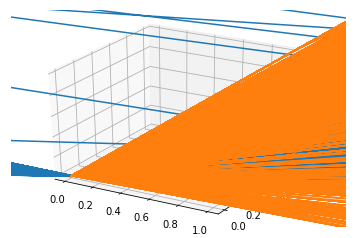